# Starting EDA of pH project

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from sklearn.linear_model import LinearRegression
import seaborn as sns

pd.set_option('display.max_colwidth', 30)

#### Import data and format style

In [213]:
csv_file = "../Data/R12-over-10-copies.csv"
df = pd.read_csv(csv_file)
df.rename(columns={'Count':'Copy Num'}, inplace=True)
df.head()

,Sequence,Copy Num
0,AGTGCCATCGTGCGTATCCTTCACTC...,91
1,AGTGCCATCGTGCGTATCCTTCACGT...,86
2,AGTGCCATCGTGCGTATCCTGAACAT...,83
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80
4,AGTGCCATCGTGCGTATCCTGAACAT...,78


#### Data Integrity

In [214]:
df.shape

(10383, 2)

In [215]:
sum(df.iloc[:, 0].isnull())

0

In [216]:
sum(df.iloc[:, 1].isnull())

0

In [217]:
df.dtypes

Sequence    object
Copy Num     int64
dtype: object

In [218]:
# check base type proportions
def base_count(text):
    return dict(Counter(text))   

In [219]:
df['Base Counts'] = df['Sequence'].apply(base_count)

df['A'] = df['Base Counts'].astype(object).apply(lambda x: x.get('A', np.nan))
df['C'] = df['Base Counts'].astype(object).apply(lambda x: x.get('C', np.nan))
df['T'] = df['Base Counts'].astype(object).apply(lambda x: x.get('G', np.nan))
df['G'] = df['Base Counts'].astype(object).apply(lambda x: x.get('T', np.nan))

In [220]:
base_columns = ['A', 'C', 'G', 'T']
colors = ['red', 'green', 'orange', 'purple']
base_colors = dict(zip(base_columns, colors))
df.head().iloc[:, 3:]

,A,C,T,G
0,24,26,26,22
1,22,27,29,20
2,23,23,29,23
3,24,25,28,21
4,24,21,30,23


In [221]:
df['Length'] = df['Sequence'].apply(len)

In [222]:
sum((np.sum(df[base_columns], axis=1) == df['Length']).isnull()) # Checks base counts add up to length of sequence

0

In [223]:
allowed_keys = {'A', 'C', 'T', 'G'} # Checks that there are no weird nonstandard bases
df['Nonstandard base'] = df['Base Counts'].astype(object).apply(lambda x: not set(x.keys()).issubset(allowed_keys))
np.sum(df['Nonstandard base'])

0

In [224]:
df.head()

,Sequence,Copy Num,Base Counts,A,C,T,G,Length,Nonstandard base
0,AGTGCCATCGTGCGTATCCTTCACTC...,91,"{'A': 24, 'G': 26, 'T': 22...",24,26,26,22,98,False
1,AGTGCCATCGTGCGTATCCTTCACGT...,86,"{'A': 22, 'G': 29, 'T': 20...",22,27,29,20,98,False
2,AGTGCCATCGTGCGTATCCTGAACAT...,83,"{'A': 23, 'G': 29, 'T': 23...",23,23,29,23,98,False
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80,"{'A': 24, 'G': 28, 'T': 21...",24,25,28,21,98,False
4,AGTGCCATCGTGCGTATCCTGAACAT...,78,"{'A': 24, 'G': 30, 'T': 23...",24,21,30,23,98,False


In [225]:
df['Length'].value_counts().sort_values(ascending=False)

Length
98     9893
97      325
99       65
96       42
95       11
94        7
88        7
87        4
91        4
84        3
90        3
93        3
86        3
85        3
92        3
89        1
107       1
102       1
108       1
82        1
100       1
83        1
Name: count, dtype: int64

The sequences range in length from 82 to 108, but most commonly at 98.
As I recally, NGS clips the first few base pairs down from nominal 100 because of poor quality.
The other variants in sequence length are likely due to mutations from PCR errors.

In [226]:
v_df = df # Save a verbose version of df
df = df[['Sequence', 'Length', 'Copy Num', 'A', 'C', 'T', 'G']]
df.head()

,Sequence,Length,Copy Num,A,C,T,G
0,AGTGCCATCGTGCGTATCCTTCACTC...,98,91,24,26,26,22
1,AGTGCCATCGTGCGTATCCTTCACGT...,98,86,22,27,29,20
2,AGTGCCATCGTGCGTATCCTGAACAT...,98,83,23,23,29,23
3,AGTGCCATCGTGCGTATCCCGCTCCG...,98,80,24,25,28,21
4,AGTGCCATCGTGCGTATCCTGAACAT...,98,78,24,21,30,23


In [227]:
for col in base_columns:
    df.loc[:, col] = df[col]/df['Length']

In [228]:
df.head()

,Sequence,Length,Copy Num,A,C,T,G
0,AGTGCCATCGTGCGTATCCTTCACTC...,98,91,0.244898,0.265306,0.265306,0.224490
1,AGTGCCATCGTGCGTATCCTTCACGT...,98,86,0.224490,0.275510,0.295918,0.204082
2,AGTGCCATCGTGCGTATCCTGAACAT...,98,83,0.234694,0.234694,0.295918,0.234694
3,AGTGCCATCGTGCGTATCCCGCTCCG...,98,80,0.244898,0.255102,0.285714,0.214286
4,AGTGCCATCGTGCGTATCCTGAACAT...,98,78,0.244898,0.214286,0.306122,0.234694


## Examine basic properties

### 1. Copy Number of a sequence

In [229]:
df['Copy Num'].describe()

count    10383.000000
mean        14.926900
std          6.640851
min         10.000000
25%         11.000000
50%         13.000000
75%         16.000000
max         91.000000
Name: Copy Num, dtype: float64

Copy Number of a sequence in the pool is between 10 to 91.  10 is the minimum bc that is where we set the minimum for consideration, but when we retrieve the full dataset the counts will range from 1 to max.

How many sequences have only 10 copies in the pool? 91 copies?
To get a bird's eye view, we plot a histogram of the counts.

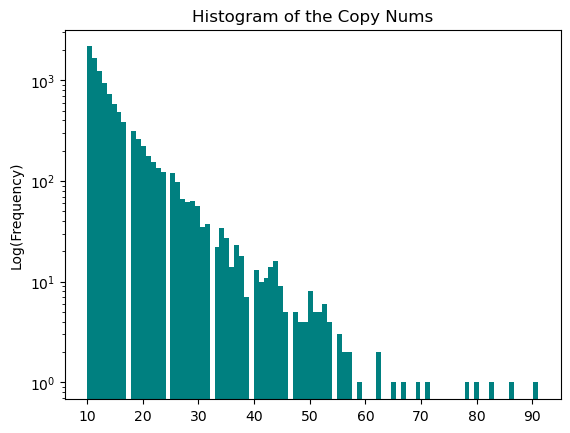

In [230]:
plt.hist(df['Copy Num'].values, bins=92, color='teal')
plt.title('Histogram of the Copy Nums')
plt.yscale('log')
plt.ylabel('Log(Frequency)')
plt.show()

Most of the sequences in the pool have fewer than 30 copies. There is a long right tail with a few sequences having about 10-fold higher copy number. The high copy number sequences, and in particular the 91 copy number sequence, may be of greater interest because it is an indirect measure of greater pH-activity (fitness).

(Generally, enrichment leads to a handful of sequences dominating the pool because of convergence towards the highest fitness moieties. However, 100 copies in a 2e6 pool is in the noise compared to the usual outcome.)

#### Boxplot of Copy Numbers

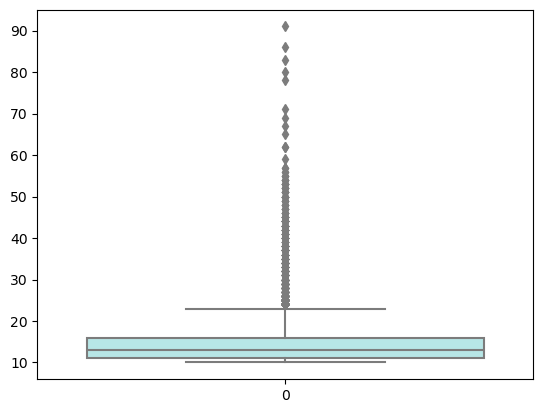

In [231]:
sns.boxplot(df['Copy Num'].values, color='paleturquoise')
plt.show()

### 2. Length of a sequence

In [232]:
df['Length'].describe()

count    10383.000000
mean        97.929115
std          0.677246
min         82.000000
25%         98.000000
50%         98.000000
75%         98.000000
max        108.000000
Name: Length, dtype: float64

#### Histogram of Lengths

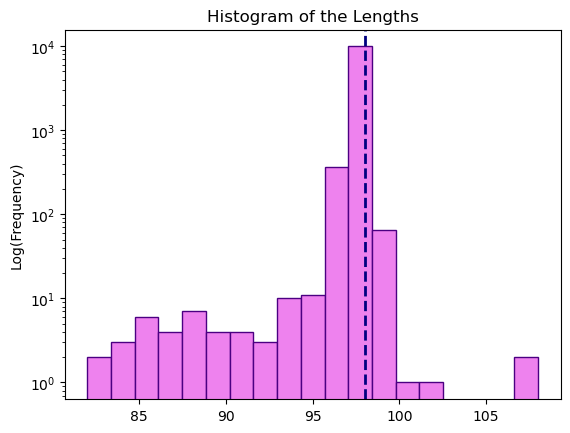

In [233]:
bins = np.linspace(82, 108, 20)
plt.hist(df['Length'], color='violet', bins=bins, edgecolor='indigo')
plt.title('Histogram of the Lengths')
plt.yscale('log')
plt.ylabel('Log(Frequency)')
plt.axvline(x=98, color='navy', linestyle='--', linewidth=2, label='98 bp')
plt.show()

Plotted on a log scale to more effectively show the distribution. We see right skewed data to my surprise, with a number of sequences cleaved to shorter than original library.

Nominally, the random initial library was 100 bp, and bc of the nature of NGS, the first 2 bp reads are discarded bc of poor quality, so we expect that sequences should have 98 bp.  (We can later add these bases back bc we know the first two bases since these were constant primer sites.)

Due to mutations, there is some dispersion around 98 bp, where max length is up to 108 and min at 82.

#### Boxplot of lengths

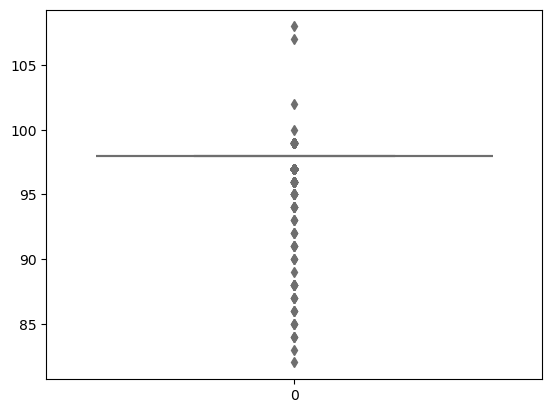

In [234]:
sns.boxplot(df['Length'].values, color='violet')
plt.show()

### 3. Base composition

#### Histogram of %base

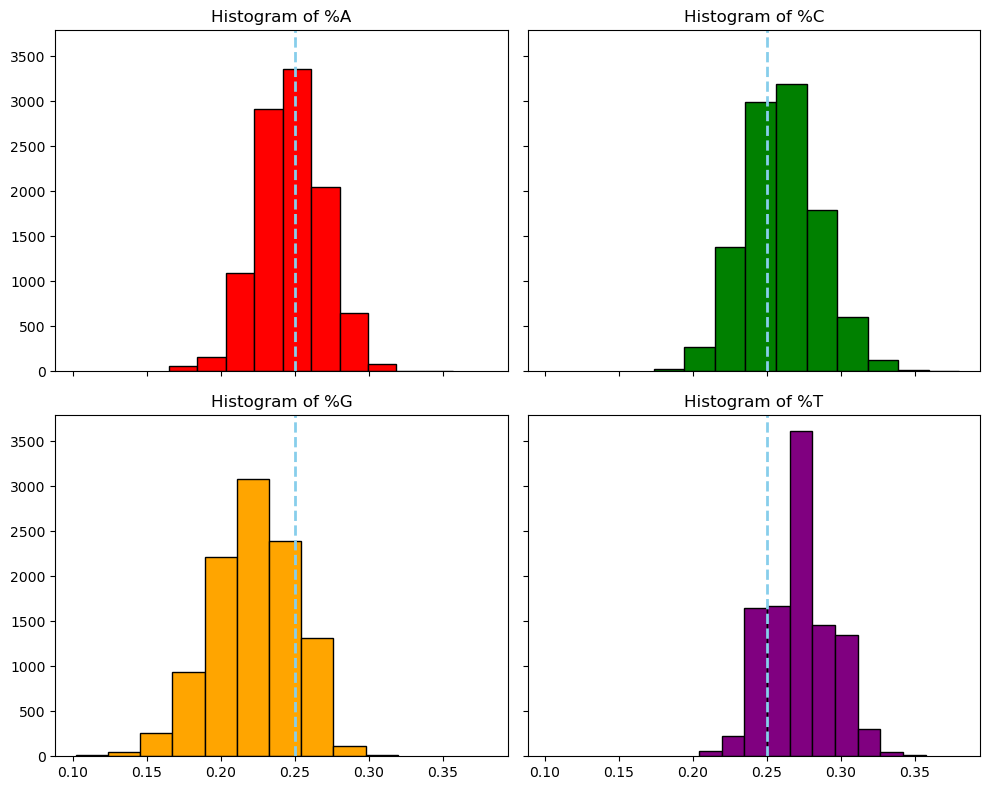

In [235]:
INIT_FRAC = 0.25

fig, axes = plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)
                        
for base, ax in zip(base_columns, axes.flatten()):
    ax.hist(df[base], color=base_colors[base], edgecolor='black')
    ax.set_title(f'Histogram of %{base}')
    ax.axvline(x=INIT_FRAC, color='skyblue', linestyle='--', linewidth=2)
 
plt.tight_layout()
plt.show()

Most sequences have a lower %G and a higher %T.
%A and %C are evenly distributed around initial %.

We consider the R12 pool to be highly enriched for fitness, so these characteristics may describe rules for high pH-activity.  Since we consider high copy number to be a marker for greatest fitness, we will later study %base for those sequences, and check corr of %base with copy number.

In [236]:
base_frac_stats = pd.DataFrame([df[base].describe() for base in base_columns])
base_frac_stats['range'] = base_frac_stats['max'] - base_frac_stats['min']
np.round(base_frac_stats, 2)

,count,mean,std,min,25%,50%,75%,max,range
A,10383.0,0.25,0.02,0.16,0.23,0.24,0.27,0.36,0.19
C,10383.0,0.26,0.02,0.17,0.24,0.27,0.28,0.38,0.21
G,10383.0,0.22,0.03,0.10,0.20,0.22,0.23,0.32,0.22
T,10383.0,0.27,0.02,0.20,0.26,0.27,0.29,0.36,0.15


C and T have the highest median percent fractions in the pool. G is the lowest at 0.22.
Standard deviation is about the same for all bases.
G has the largest range of values. 
The mean is close to the median for all, so I would say the base proportions are evenly distributed, not skew.

Given that the randomized regions should have approximately 25-25-25-25 makeup, we also calculated the percent difference from 0.25.  But we should keep in mind that the primer regions were designed and are expected to be relatively constant - we may choose to compare to a study where we consider only the variable regions.

In [237]:
# save verbose frac stats
v_base_frac_stats = base_frac_stats
base_frac_stats = base_frac_stats.iloc[:, [1, 3, 4, 5, 6, 7]]
base_frac_stats

,mean,min,25%,50%,75%,max
A,0.245924,0.164948,0.234694,0.244898,0.265306,0.357143
C,0.263716,0.173469,0.244898,0.265306,0.275510,0.380000
G,0.220563,0.102041,0.204082,0.224490,0.234694,0.319588
T,0.269797,0.204082,0.255102,0.265306,0.285714,0.357143


#### Bar plots comparing %base with initial %

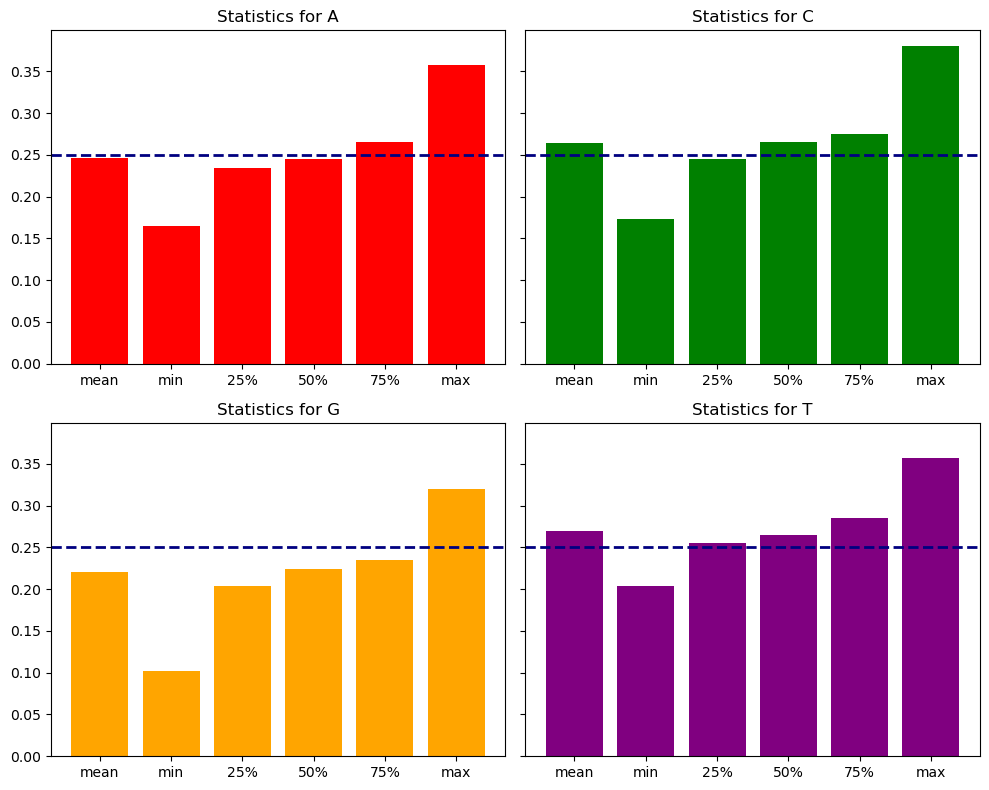

In [238]:
INIT_FRAC = 0.25
categories = base_frac_stats.columns.values

fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True)
                        
for base, ax in zip(base_columns, axes.flatten()):
    values = base_frac_stats.loc[base]
    ax.bar(categories, values, color=base_colors[base])
    ax.axhline(y=INIT_FRAC, color='navy', linestyle='--', linewidth=2)
    ax.set_title(f'Statistics for {base}')

plt.tight_layout()
plt.show()

Dashed line indicates 0.25 even fractions.
Easy to see that median G composition is notably lower than an even split.
Median T and C composition is a bit higher than initial fraction.

#### Percent difference between %base compared to initial

In [239]:
base_frac_stats

,mean,min,25%,50%,75%,max
A,0.245924,0.164948,0.234694,0.244898,0.265306,0.357143
C,0.263716,0.173469,0.244898,0.265306,0.275510,0.380000
G,0.220563,0.102041,0.204082,0.224490,0.234694,0.319588
T,0.269797,0.204082,0.255102,0.265306,0.285714,0.357143


In [240]:
# Find percent difference of these stats from expected even base split
np.round((base_frac_stats - 0.25)/0.25 * 100, 1)

,mean,min,25%,50%,75%,max
A,-1.6,-34.0,-6.1,-2.0,6.1,42.9
C,5.5,-30.6,-2.0,6.1,10.2,52.0
G,-11.8,-59.2,-18.4,-10.2,-6.1,27.8
T,7.9,-18.4,2.0,6.1,14.3,42.9


Median values deviate from initial % by up to 10.2%, which suggests that enrichment process has biased the pool.  Bias away from initial fractions is a marker of convergence towards fitness.

## Examine correlations between features
We have three first order features: Copy Number, Length, %base composition.
We will examine correlations between Copy Number v Length and Copy Number v %base composition.  Copy Number is an indicator for fitness, so we may be able to uncover characteristics of sequences which boost fitness.

#### Scatter plot of Copy Number vs %Base compsotion

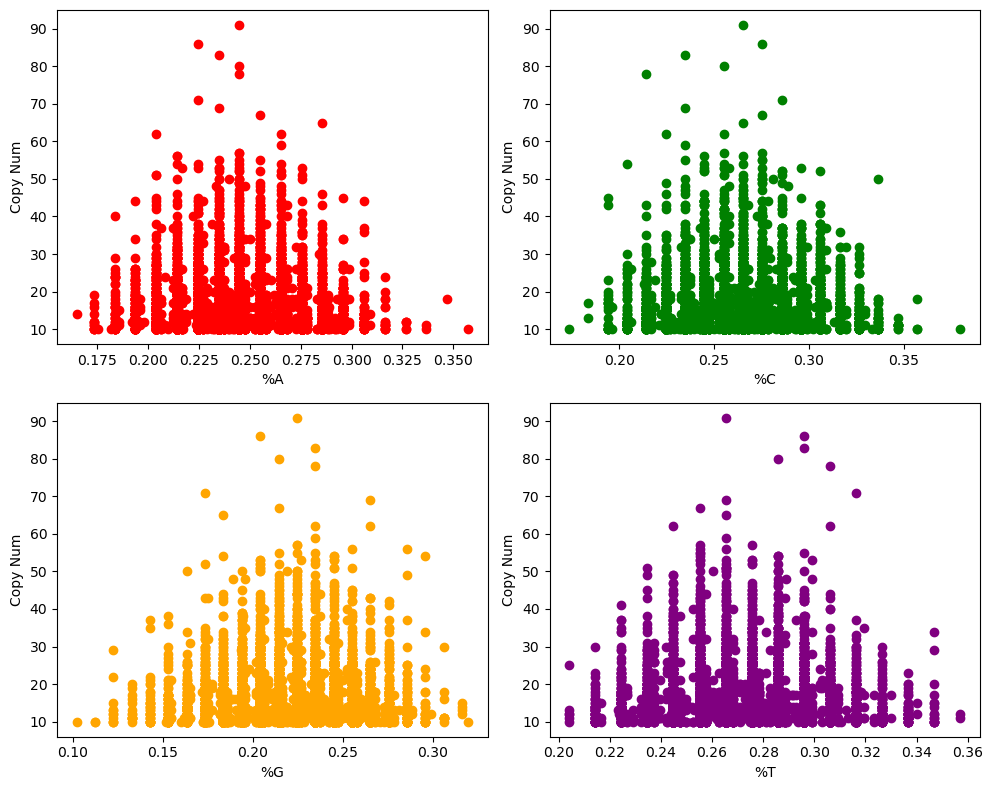

In [241]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# Plot Each Base Fraction
for ax, base in zip(axes.flatten(), base_columns):
    ax.scatter(df[base], df['Copy Num'], color=base_colors[base])
    ax.set_xlabel(f'%{base}')
    ax.set_ylabel('Copy Num')

plt.tight_layout()
plt.show()

#### Pearson's correlation

In [242]:
from scipy.stats import pearsonr

for base in base_columns:
    corr, p_value =pearsonr(df[base], df['Copy Num'])
    print(f'%{base} - Copy Num Correlation: r={corr:.5f}, p={p_value:.5f}')

%A - Copy Num Correlation: r=-0.04910, p=0.00000
%C - Copy Num Correlation: r=-0.00657, p=0.50350
%G - Copy Num Correlation: r=0.03142, p=0.00136
%T - Copy Num Correlation: r=0.02038, p=0.03784


Calculation of Pearson's correlation shows that there are only weak correlations between %base composition and the copy number. This confirms our assumption that sequence composition cannot account for fitness, and merits study of second order properties such as k-mer motifs and secondary structure folding.

### Bar plot of Variance of %base compostion
We calculated the variance of %base composition for moieties with the same copy number, and variance decreases with higher copy number. Since we know from the previous histogram of copy numbers that fewer sequences have a high copy number (and also because we expect the outcome of enrichment is sequence convergence), this result is expected.

For example, the moiety with 91 copies in the pool are all the same, so no variance in base composition. Whereas, there are many more  moieties in the pool which have the 10 copies and they are all different, so there will be greater variance in composition.

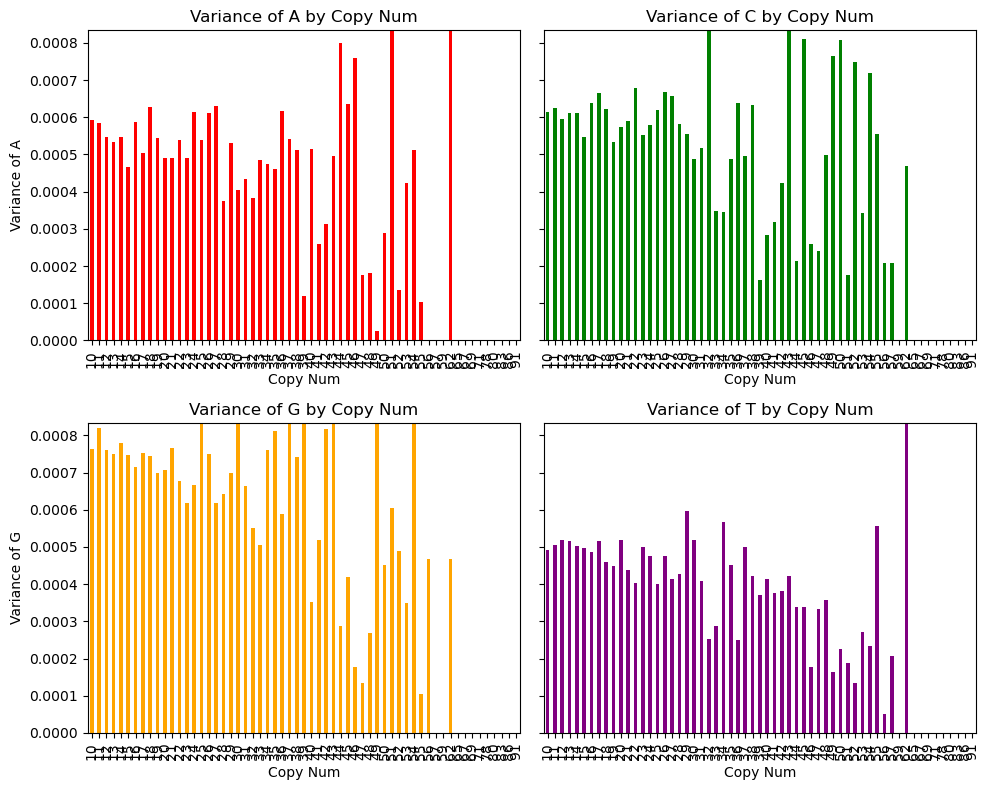

In [178]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

# Compute global max variance for consistency
max_variance = max(df[col].var() for col in base_columns)

for col, ax in zip(base_columns, axes.flatten()):
    grouped_variance = df.groupby('Copy Num')[col].var()
    grouped_variance.plot(kind='bar', ax=ax, color=base_colors[col])
    ax.set_title(f'Variance of {col} by Copy Num')
    ax.set_xlabel('Copy Num')
    ax.set_ylabel(f'Variance of {col}')
    ax.set_ylim(0, max_variance * 1.1)
    
plt.tight_layout()
plt.show()

### TODO Correlation of Length with Copy Num

### TODO heatmap to spot patterns

## Conclusions
As we expected, preliminary EDA of basic sequence properties like count, length, %base composition did not reveal a smoking gun for the mechanism of pH-activity.

It makes sense to investigate second order effects such as:  
(1) Base pair combinations (kmer motifs)  
(2) Secondary structure prediction and folding energy scores